# Binary classification project: Supervised learning

- The objective of this project is to develop a supervised learning model that can predict financial risk for agricultural enterprises. 

- The dataset farm_data_train.csv for training contains farms which are categorized into two groups: 'healthy' and 'defaulting' farms. 

- The aim is to construct a financial risk detection score applicable to agricultural operations. For this purpose, a set of financial ratios has been measured for each agricultural operation (R2, R14, R17, R32).

In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from classification_workflow import *
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import seaborn as sns

# Exploring the dataset
**The first step is to explore our data to make sure whether it is clean or contains outliers.**

In [13]:
#Explore the data 
farm= pd.read_csv('farm_data_train.csv') # read the training data 
farm.head() #Print the first 5 elements of the data
farm.info() #Give information about the data
nan_count = farm[farm.isna().any(axis=1)].shape[0] #Caculate the number of non-values present in the data
print(f"Number of rows : {len(farm)}")
print(f"Number of rows with at least one NAN value: {nan_count}")
print(f"{round(nan_count/len(farm) * 100)}% of our rows have at least one"
      f" missing value")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R2      945 non-null    float64
 1   R14     945 non-null    float64
 2   R17     945 non-null    float64
 3   R32     945 non-null    float64
 4   DIFF    945 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 37.0 KB
Number of rows : 945
Number of rows with at least one NAN value: 0
0% of our rows have at least one missing value


In [14]:
#Check missing data
missing_data = farm.isnull().sum()
print("\nMissing data:")
print(missing_data)



Missing data:
R2      0
R14     0
R17     0
R32     0
DIFF    0
dtype: int64


**Comment: The data doesn't contain NaN values. There's no missed values.**

In [9]:
farm.sample(6)


,R2,R14,R17,R32,DIFF
211,0.737,0.5452,0.0598,0.2603,0
789,0.632,0.7805,0.0202,0.4026,1
860,0.500,0.9444,0.0459,0.2069,1
266,0.834,1.4321,0.0701,0.0843,1
355,0.801,0.2760,0.0186,0.3005,0
42,0.699,0.2348,0.0720,0.2922,0


In [16]:
farm.describe().T

,count,mean,std,min,25%,50%,75%,max
R2,945.0,0.524635,0.287329,0.00000,0.3350,0.5800,0.7550,0.9540
R14,945.0,0.690901,0.634007,-0.68500,0.2169,0.4475,1.0050,2.9695
R17,945.0,0.064560,0.025861,0.00599,0.0450,0.0623,0.0823,0.1940
R32,945.0,0.252643,0.117565,-0.16200,0.1758,0.2687,0.3384,0.4881
DIFF,945.0,0.478307,0.499794,0.00000,0.0000,0.0000,1.0000,1.0000


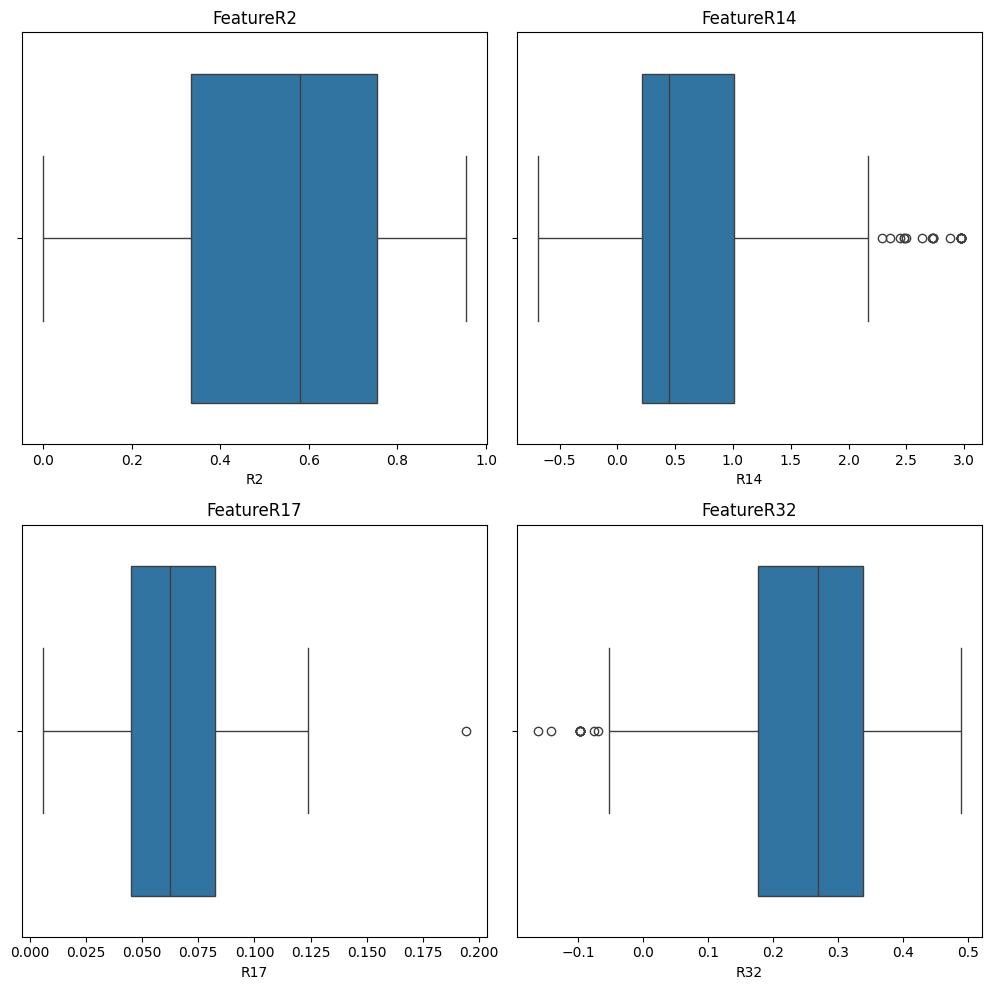

In [20]:
num_feature = ['R2', 'R14', 'R17', 'R32']
num_rows = 2
num_columns = 2
fig, axes = plt.subplots(num_rows, num_columns, figsize =(10, 10))
axes = axes.flatten()
for i in range(len(num_feature), len(axes)):
    fig.delaxes(axes[i])

for i in range (len(num_feature)):
    sns.boxplot(data =farm, x= farm[num_feature[i]], ax = axes[i])
    axes[i].set_title(f"Feature{num_feature[i]}")

plt.tight_layout()
plt.show()

### Outliers detection

In [ ]:
def find_outliers(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[feature] < lower_bound | data[feature] > upper_bound)]
    return outliers

outliers_dict = {}
for feature in farm.select_dtypes(include = ['float64', 'int64']).columns:
    outliers = find_outliers(farm, feature)
    outliers_dict[feature] = len(outliers)
    print(f"{feature} has {len(outliers)} outliers")

**Histograms representing the frequency of variables**

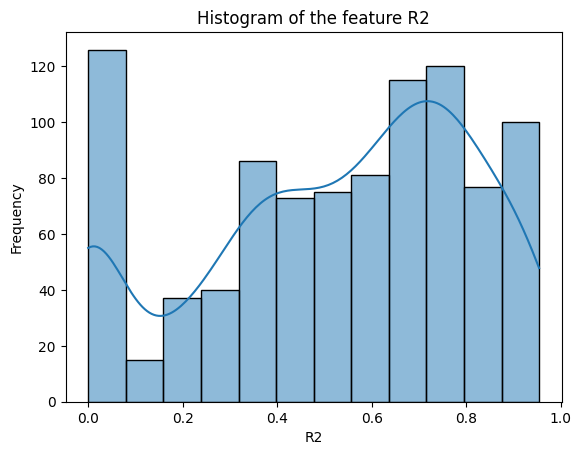

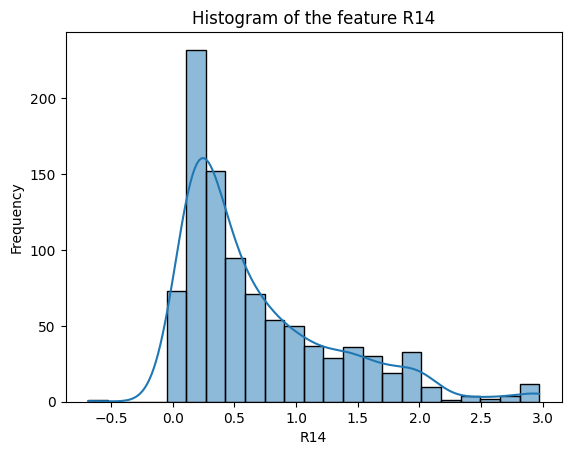

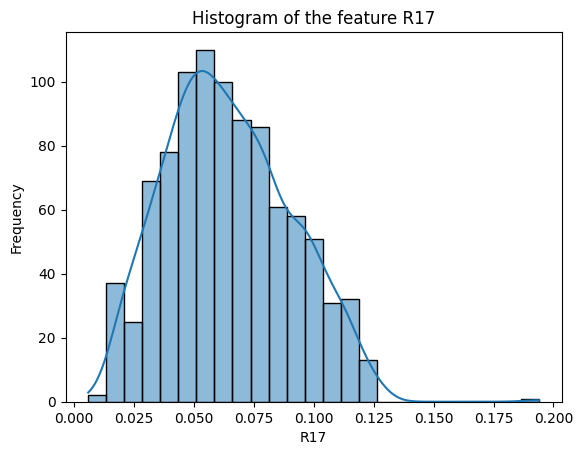

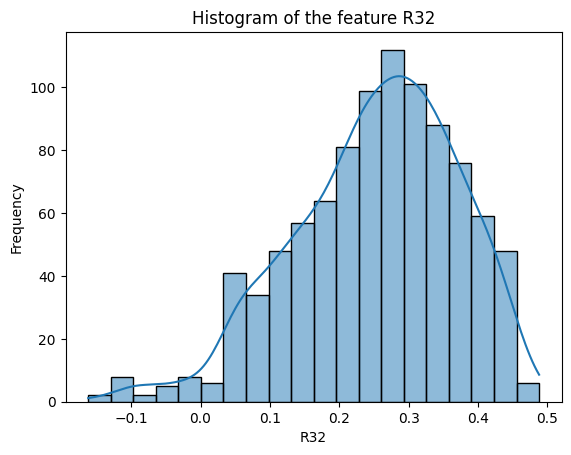

In [6]:
#Visualize the data
columns = farm.iloc[:,:-1].select_dtypes(include=['int64', 'float64']).columns.tolist()
if not columns :
        farm.hist(bins=10, figsize=(15, 10))
        plt.suptitle('Distribution of Numerical Columns', y=0.92)
        plt.show()
else :
        for c in columns :
            # Plot a histogram
            sns.histplot(farm[c], kde=True)
            plt.title(f'Histogram of the feature {str(c)}')
            plt.xlabel(str(c))
            plt.ylabel('Frequency')
            plt.show()

**Counting the number of 0 and 1 in DIFF variable** 

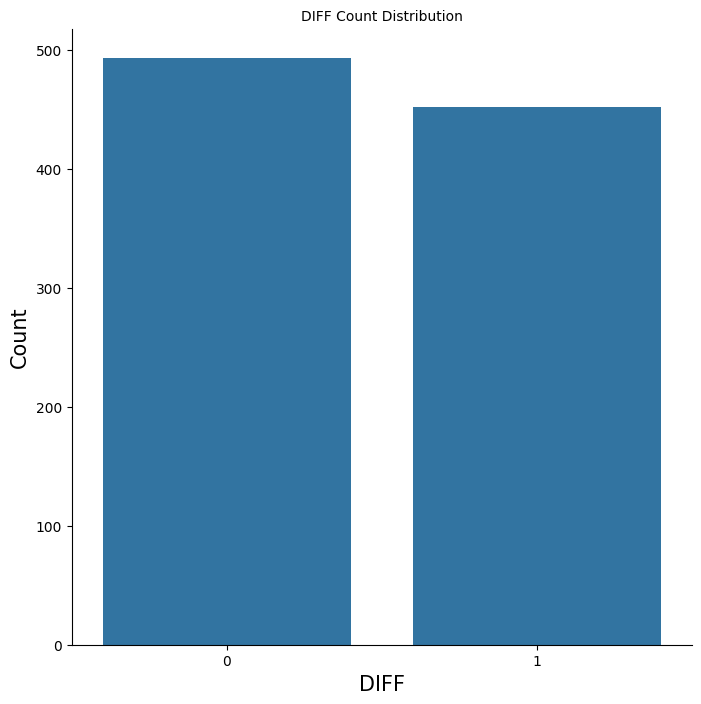

In [7]:
#Histogram of DIFF, count the number of 0 and 1 in the data
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
sns.countplot(x = 'DIFF', data = farm)
ax.set_xlabel('DIFF', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('DIFF Count Distribution', fontsize=10)
sns.despine()

**Correlation matrix**

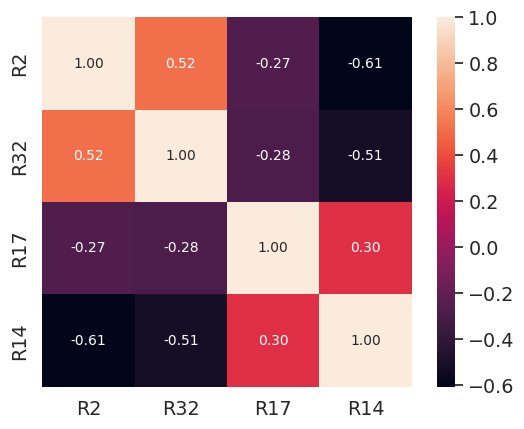

In [8]:
#Correlation matrix
k = 10 #number of variables for heatmap
import numpy as np
farm_final = farm[['R2', 'R14', 'R17','R32']]
corrmat = farm_final.corr()
cols = corrmat.nlargest(k, 'R2')['R2'].index
cm = np.corrcoef(farm[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Pairplot matrix**

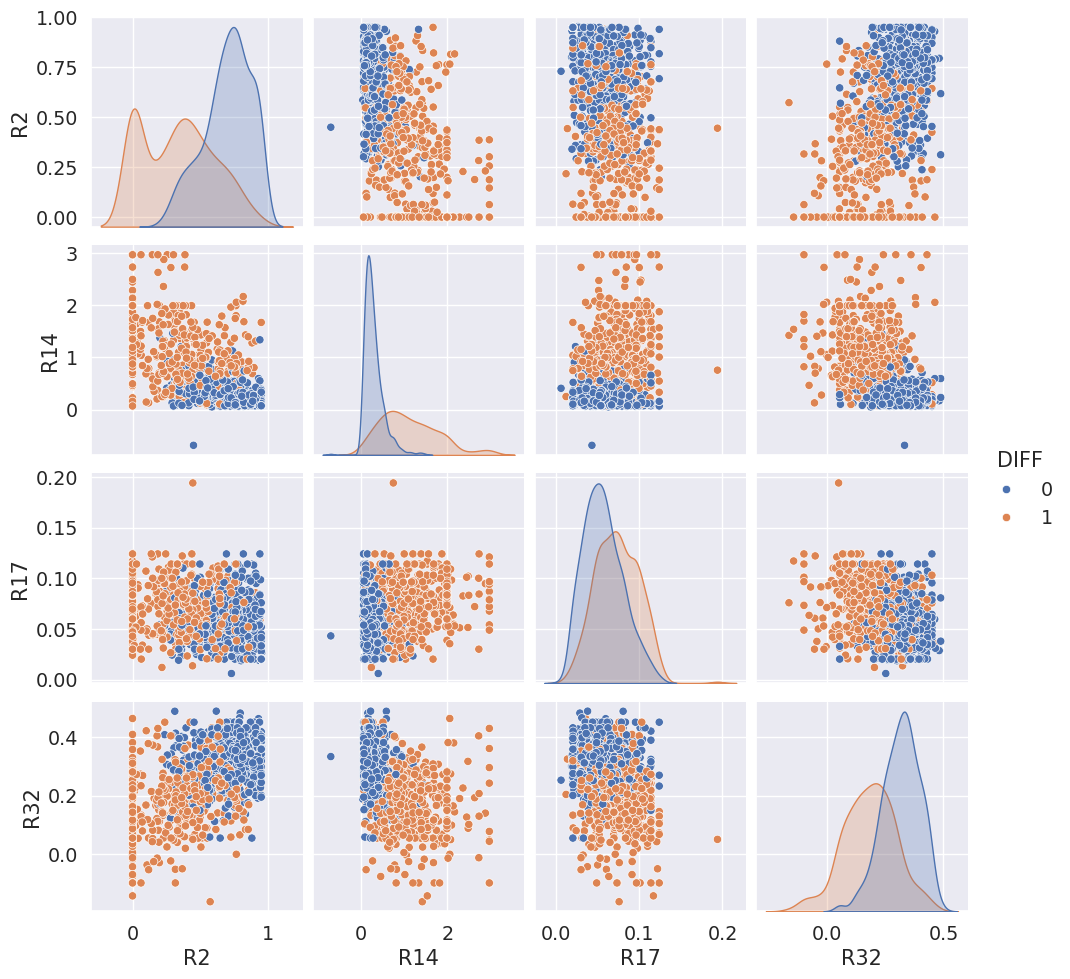

In [9]:
#Pairplot matrix (Matrice de dispersion)
pp=sns.pairplot(farm, hue='DIFF', corner=False)

# Standardization & Normalization

## Reminder

1. MinMaxScaler:

$$ X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}} $$

2. StandardScaler:

$$ X_{\text{scaled}} = \frac{X - \mu}{\sigma} $$

3. RobustScaler:

$$ X_{\text{scaled}} = \frac{X - \text{médiane}}{\text{IQR}} $$

- $\text{IQR}$: interquartile range.

In [27]:
#minmax, standard, robust 
minmax, standard, robust = standardization(farm)
#print(robust)


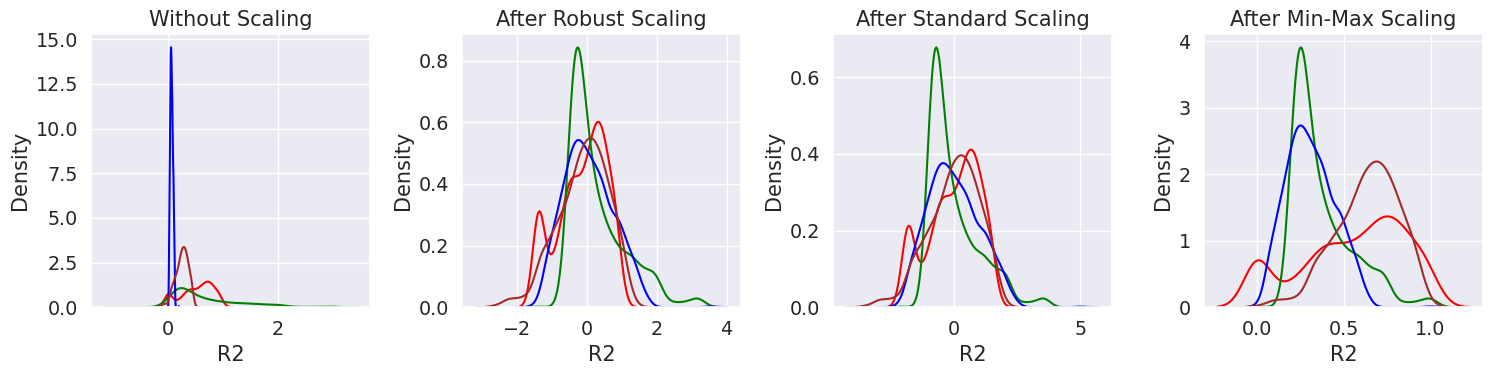

In [12]:
#Plot the densities of R2, R14, R17, R32 before and after scaling
plot_densities(farm)

A dictonnary containing the models we try to evaluate, is defined above.
The models evaluated **for the moment** are: 
1. Logistic regression.
2. Random forests.
3. SVM.
4. kneighbors.
5. Decision tree.

In [22]:
dict_models = {'Logistic Regression': {
        'model': LogisticRegression(),
        'param_grid': {
            'C': [0.0001, 0.01, 0.1, 1, 10, 100], # regulirization (inverse of lambda)
            'fit_intercept': [True, False],  # True = interception is added (b0: biais)
            'intercept_scaling': [1, 10, 100, 150]  # Traiter le déséquilibre de la répartiotion des classes de la data, liblinear solver
        }
    },
        'RandomForestClassifier': {
            'model': RandomForestClassifier(),
            'param_grid': {
                'n_estimators': [50, 100, 150, 200],
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 10, 20],
                'bootstrap': [True, False]
            }
    },
        'SVM': {
        'model': SVC(probability=True),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale', 'auto']
        }

    },
        'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
        'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    } 
}

# Binary classification

Here, the strategy is to try to train the models using diffrent types of data ie: 
1. Without scaling.
2. Robust data.
3. standard data.
4. Using Min-Max normalization.

### Without scaling

In [23]:
X = farm.drop(['DIFF'],axis=1) # 'R17','R32', R14, R2
y = farm['DIFF'] #Target

Going through each model defined in the dictionnary...:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/home/naim/Bureau/Binary-classification/classification_workflow.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)


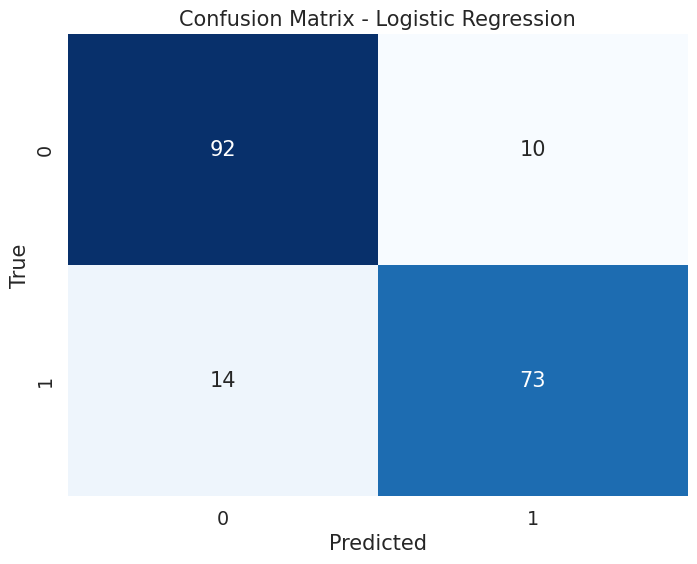

Model: Logistic Regression
Accuracy: 0.873015873015873
Precision: 0.8795180722891566
Recall: 0.8390804597701149
ROC-AUC: 0.95368492224476




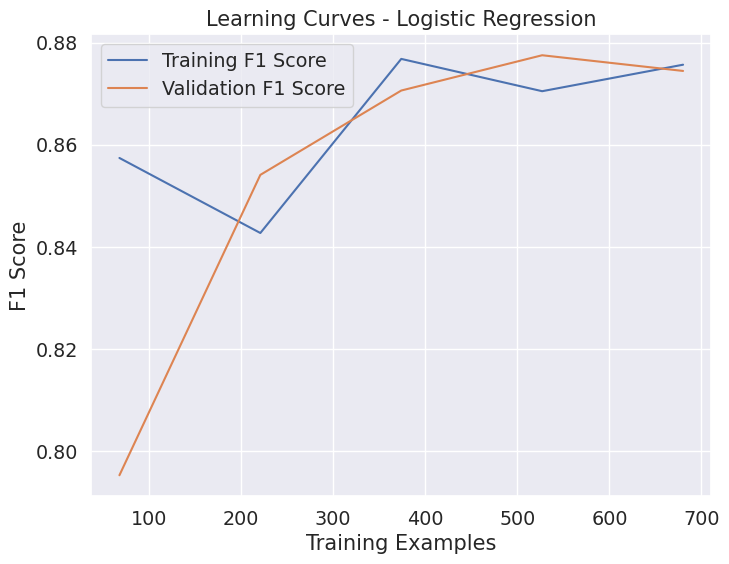

Going through each model defined in the dictionnary...:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


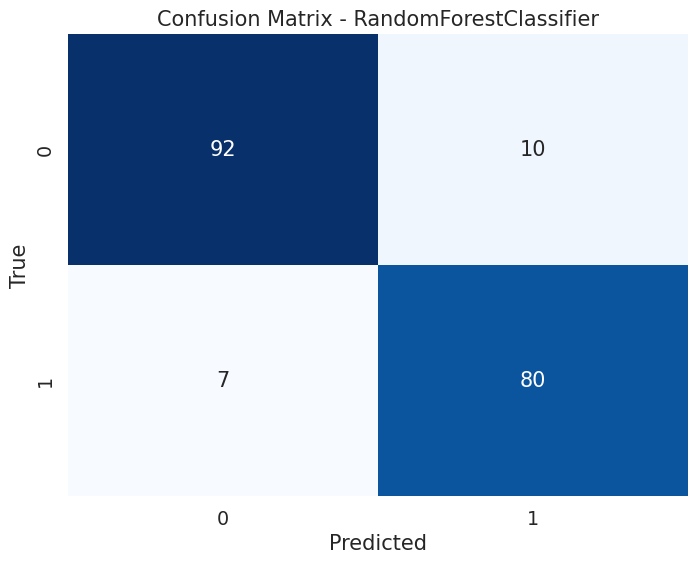

Model: RandomForestClassifier
Accuracy: 0.91005291005291
Precision: 0.8888888888888888
Recall: 0.9195402298850575
ROC-AUC: 0.9599391480730224




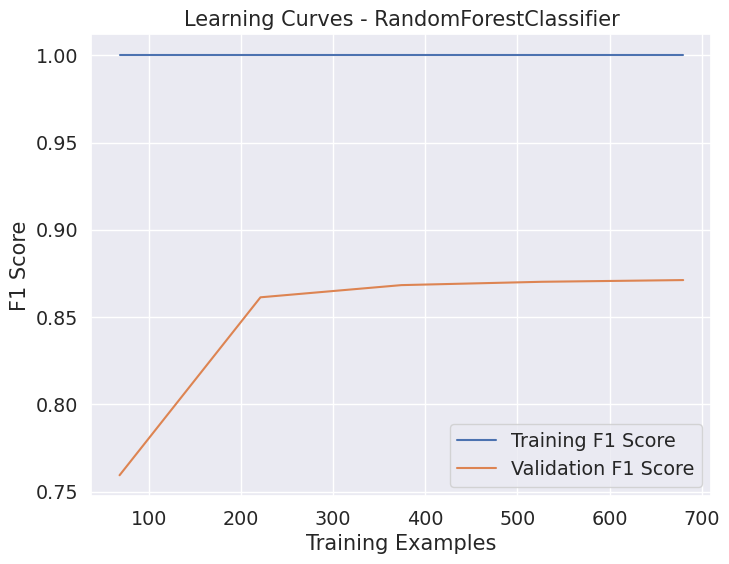

Going through each model defined in the dictionnary...:  40%|████      | 2/5 [00:57<01:40, 33.36s/it]

Fitting 10 folds for each of 24 candidates, totalling 240 fits


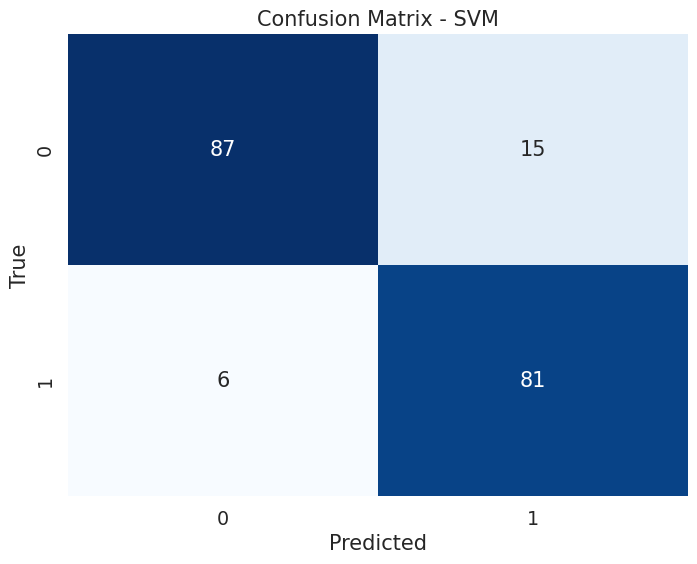

Model: SVM
Accuracy: 0.8888888888888888
Precision: 0.84375
Recall: 0.9310344827586207
ROC-AUC: 0.950191570881226




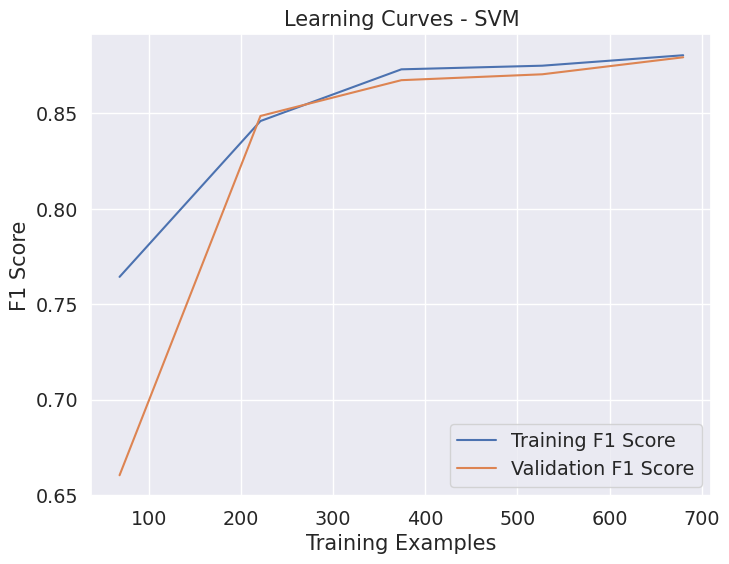

Going through each model defined in the dictionnary...:  60%|██████    | 3/5 [01:03<00:41, 20.78s/it]

Fitting 10 folds for each of 16 candidates, totalling 160 fits


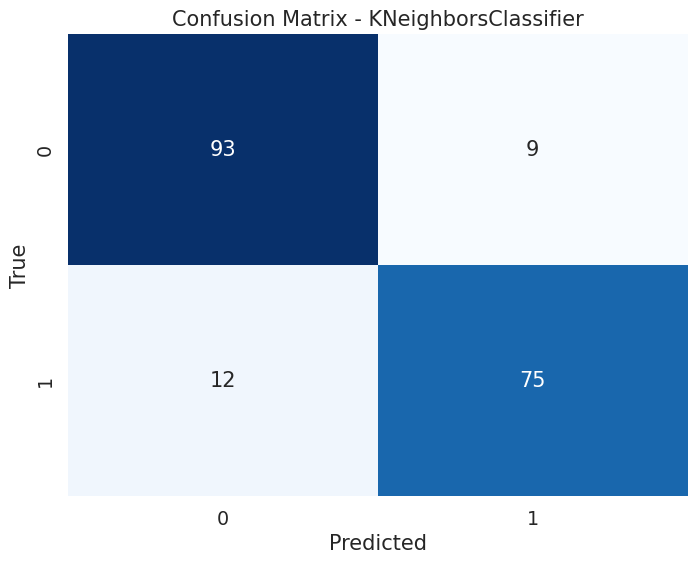

Model: KNeighborsClassifier
Accuracy: 0.8888888888888888
Precision: 0.8928571428571429
Recall: 0.8620689655172413
ROC-AUC: 0.9379648411088574




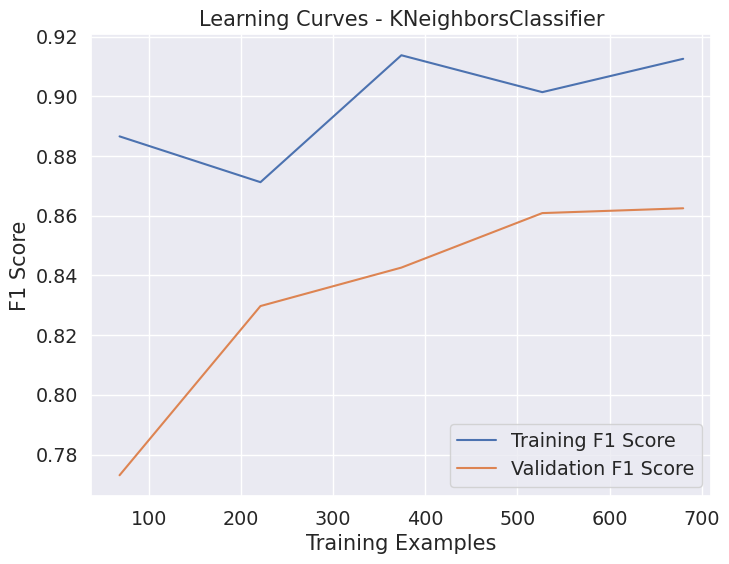

Going through each model defined in the dictionnary...:  80%|████████  | 4/5 [01:06<00:13, 13.67s/it]

Fitting 10 folds for each of 54 candidates, totalling 540 fits


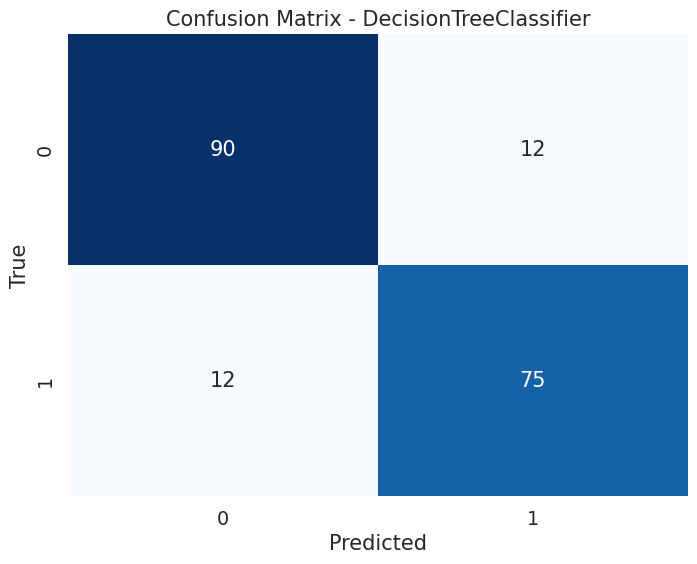

Model: DecisionTreeClassifier
Accuracy: 0.873015873015873
Precision: 0.8620689655172413
Recall: 0.8620689655172413
ROC-AUC: 0.9160468785215236




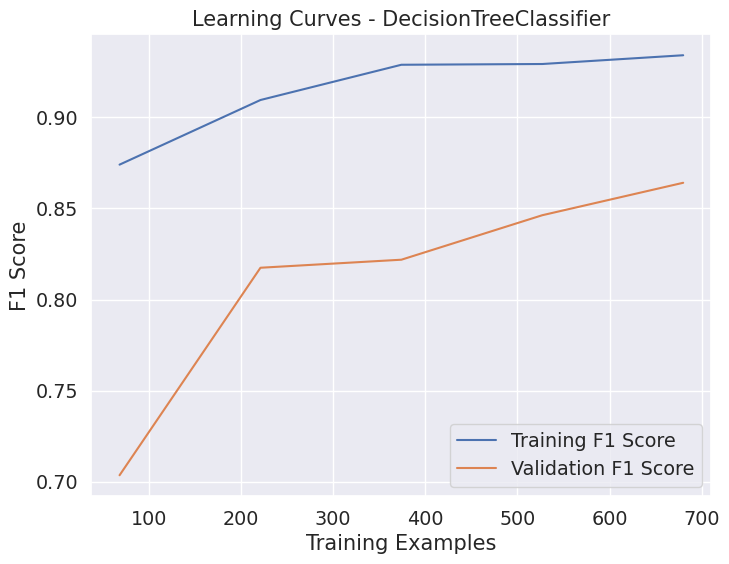

Going through each model defined in the dictionnary...: 100%|██████████| 5/5 [01:09<00:00, 13.81s/it]


,Model Name,f1 scoring on farm data(%)
0,Logistic Regression,85.880000
1,RandomForestClassifier,90.400000
2,SVM,88.520000
3,KNeighborsClassifier,87.720000
4,DecisionTreeClassifier,86.210000


In [38]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=203)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
display_results(dict_models, X_train, y_train, X_test, y_test, cv, 'f1 scoring on farm data(%)')

### Metrics to evaluate our model

### Logistic regression
- **Accuracy**: we reach nearly 87% of accuracy on our testing data.

- **Precision**: the model is able to correctly identify all positive instances with a precision score above 90%.

- **F1 Score**: the F1 score is a harmonic mean of precision and recall, which gives equal weight to both false posit.

- **ROC-AUC**: AUC is above 95%, indicating that our model performs well.

In [25]:
farm_test =pd.read_csv('farm_data_test.csv')
farm_test.head()

,R2,R14,R17,R32
0,0.837,0.07867,0.1110,0.3084
1,0.451,0.27970,0.0437,0.3479
2,0.230,0.90930,0.0562,0.1669
3,0.000,1.79410,0.1060,-0.0979
4,0.316,0.33330,0.0825,0.3357


### After robust scaling

In [30]:
Xr = robust # 'R17','R32', R14, R2
Yr = farm['DIFF'] #Target

Going through each model defined in the dictionnary...:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/home/naim/Bureau/Binary-classification/classification_workflow.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)


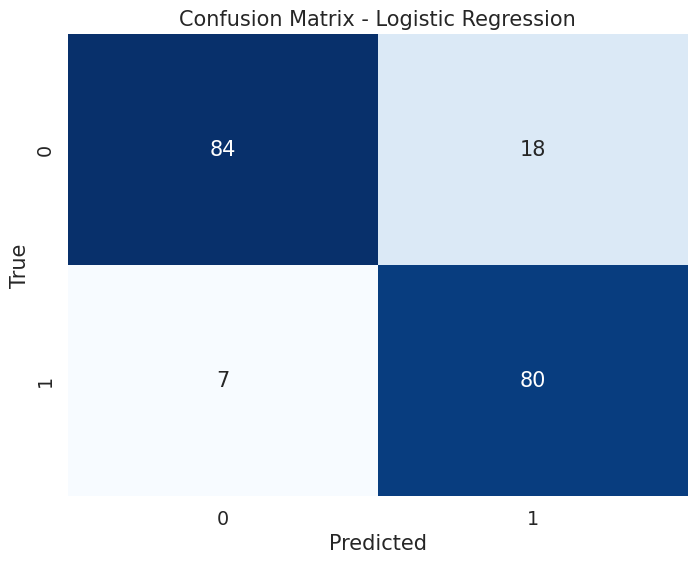

Model: Logistic Regression
Accuracy: 0.8677248677248677
Precision: 0.8163265306122449
Recall: 0.9195402298850575
ROC-AUC: 0.9491773720982646




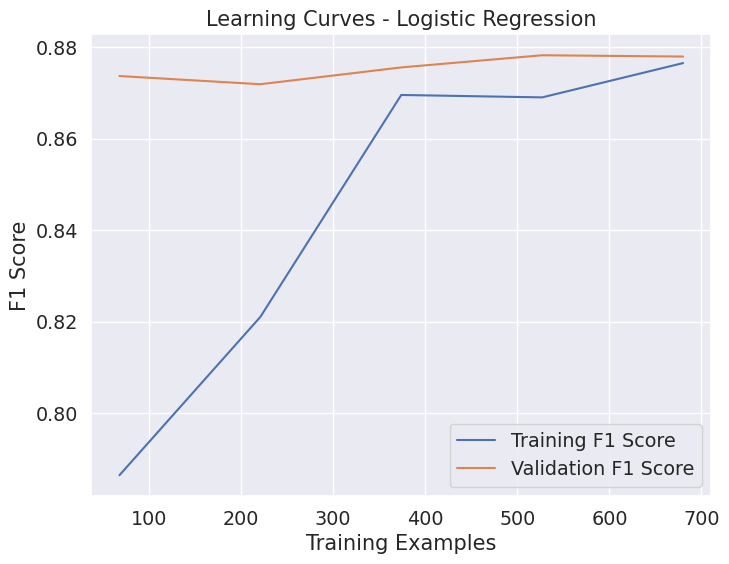

Going through each model defined in the dictionnary...:  20%|██        | 1/5 [00:02<00:11,  2.79s/it]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


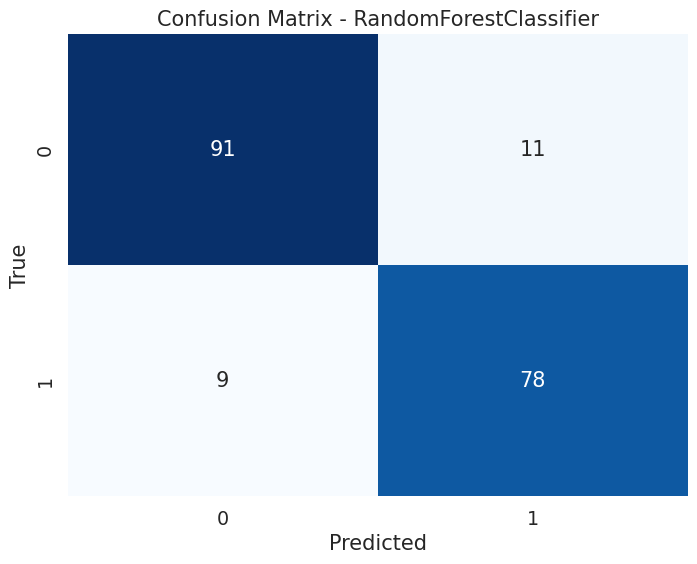

Model: RandomForestClassifier
Accuracy: 0.8941798941798942
Precision: 0.8764044943820225
Recall: 0.896551724137931
ROC-AUC: 0.9601645255803472




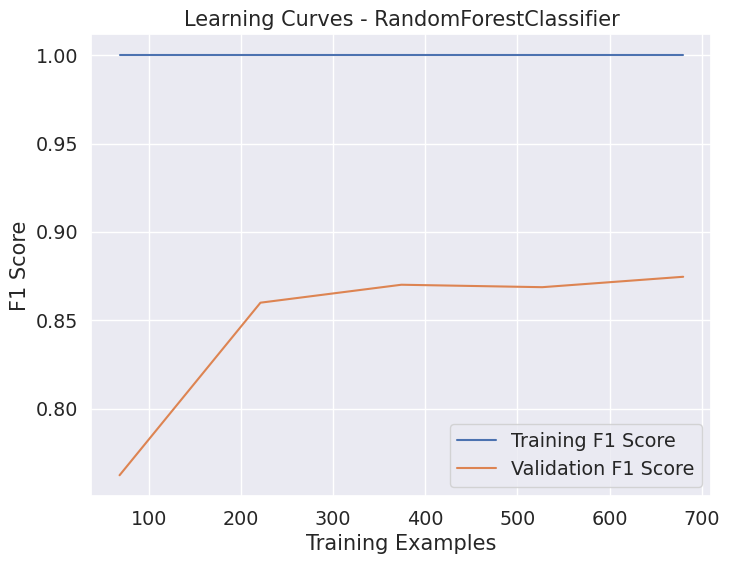

Going through each model defined in the dictionnary...:  40%|████      | 2/5 [00:58<01:41, 33.97s/it]

Fitting 10 folds for each of 24 candidates, totalling 240 fits


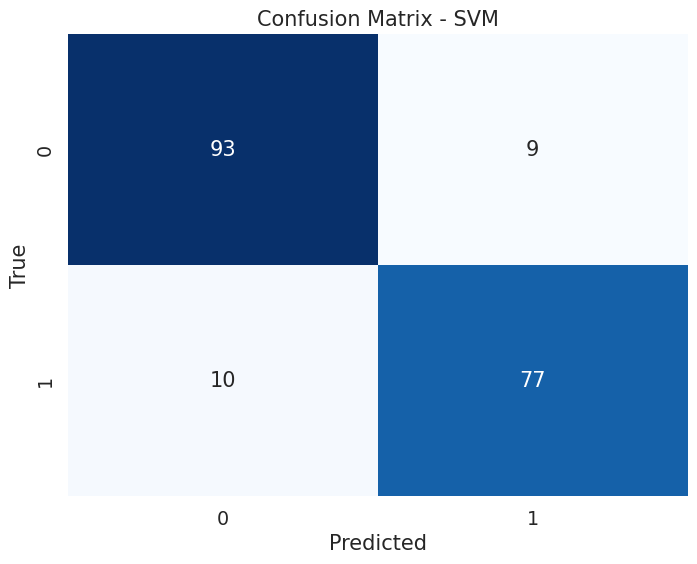

Model: SVM
Accuracy: 0.8994708994708994
Precision: 0.8953488372093024
Recall: 0.8850574712643678
ROC-AUC: 0.9521072796934865




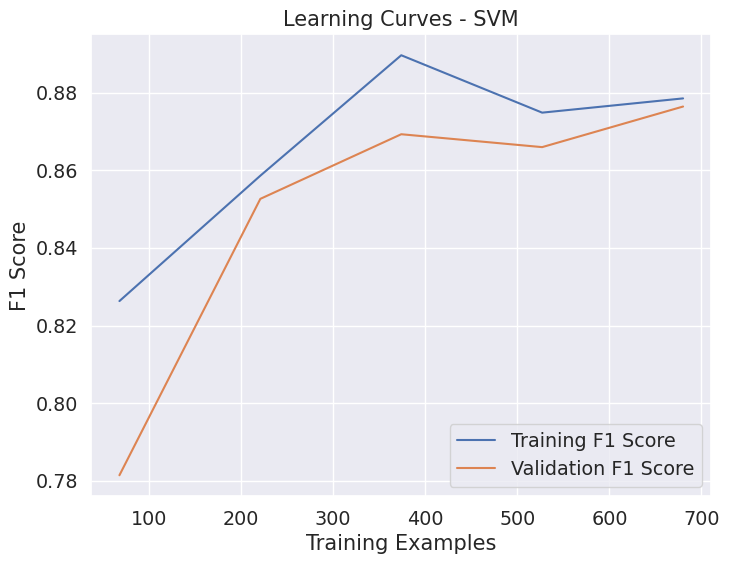

Going through each model defined in the dictionnary...:  60%|██████    | 3/5 [01:03<00:41, 20.78s/it]

Fitting 10 folds for each of 16 candidates, totalling 160 fits


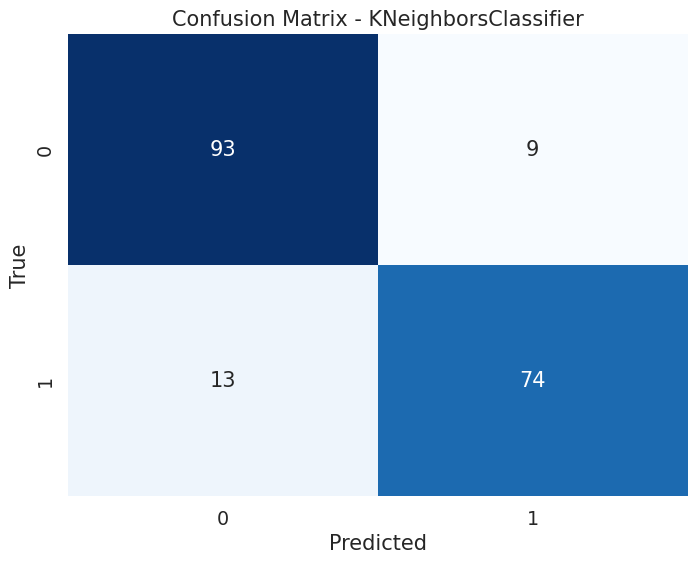

Model: KNeighborsClassifier
Accuracy: 0.8835978835978836
Precision: 0.891566265060241
Recall: 0.8505747126436781
ROC-AUC: 0.9394297949064683




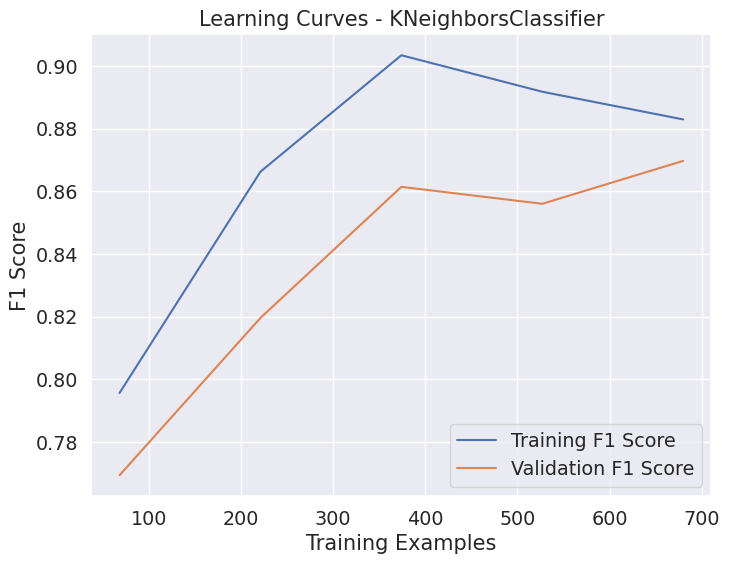

Going through each model defined in the dictionnary...:  80%|████████  | 4/5 [01:05<00:13, 13.35s/it]

Fitting 10 folds for each of 54 candidates, totalling 540 fits


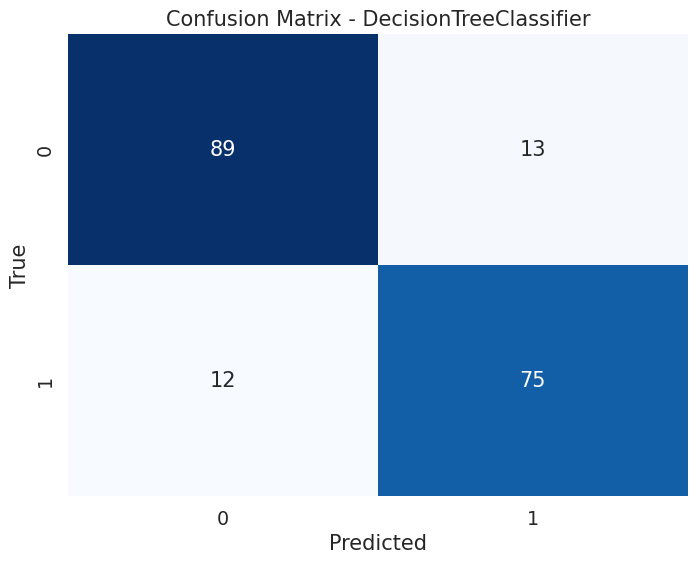

Model: DecisionTreeClassifier
Accuracy: 0.8677248677248677
Precision: 0.8522727272727273
Recall: 0.8620689655172413
ROC-AUC: 0.8756479603335589




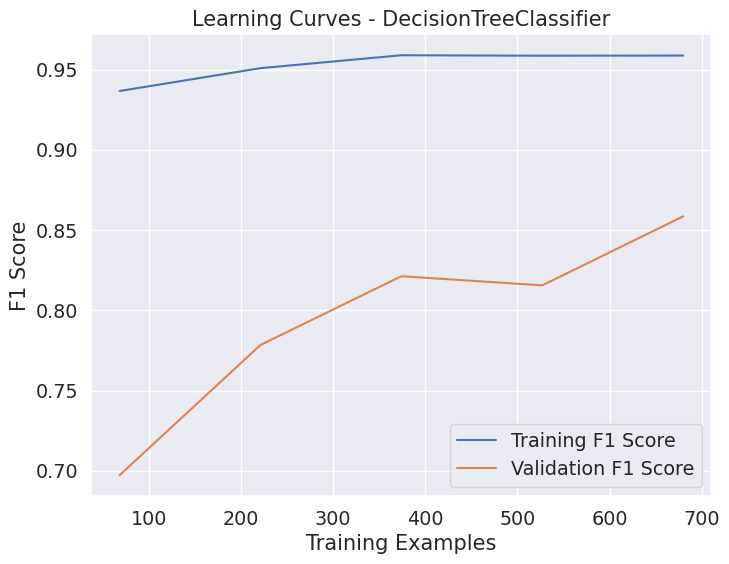

Going through each model defined in the dictionnary...: 100%|██████████| 5/5 [01:08<00:00, 13.64s/it]


,Model Name,f1 scoring on farm data(%)
0,Logistic Regression,86.490000
1,RandomForestClassifier,88.640000
2,SVM,89.020000
3,KNeighborsClassifier,87.060000
4,DecisionTreeClassifier,85.710000


In [39]:
from sklearn.model_selection import train_test_split
Xr_train,Xr_test,yr_train,yr_test = train_test_split(Xr,Yr,test_size=.20,random_state=203)
cvr = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
display_results(dict_models, Xr_train, yr_train, Xr_test, yr_test, cvr, 'f1 scoring on farm data(%)')

### After standard scaling

In [32]:
Xs = standard # 'R17','R32', R14, R2
Ys = farm['DIFF'] #Target


Going through each model defined in the dictionnary...:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/home/naim/Bureau/Binary-classification/classification_workflow.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)


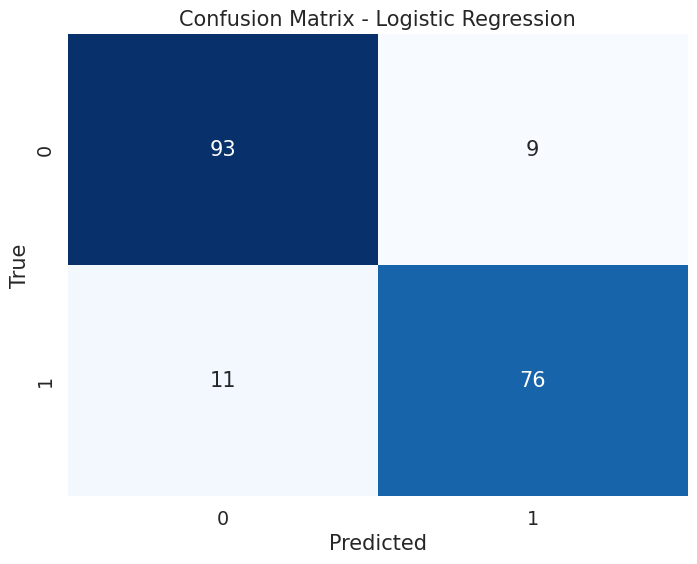

Model: Logistic Regression
Accuracy: 0.8941798941798942
Precision: 0.8941176470588236
Recall: 0.8735632183908046
ROC-AUC: 0.9526707234617985




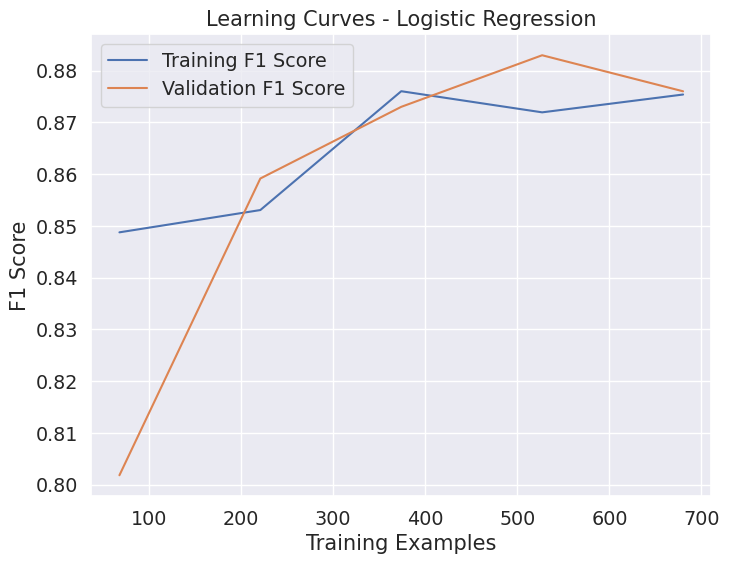

Going through each model defined in the dictionnary...:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


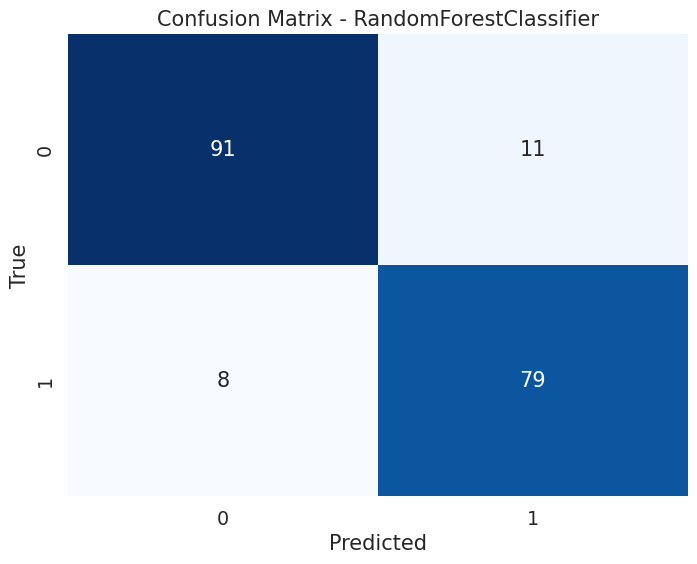

Model: RandomForestClassifier
Accuracy: 0.8994708994708994
Precision: 0.8777777777777778
Recall: 0.9080459770114943
ROC-AUC: 0.9585305386522425




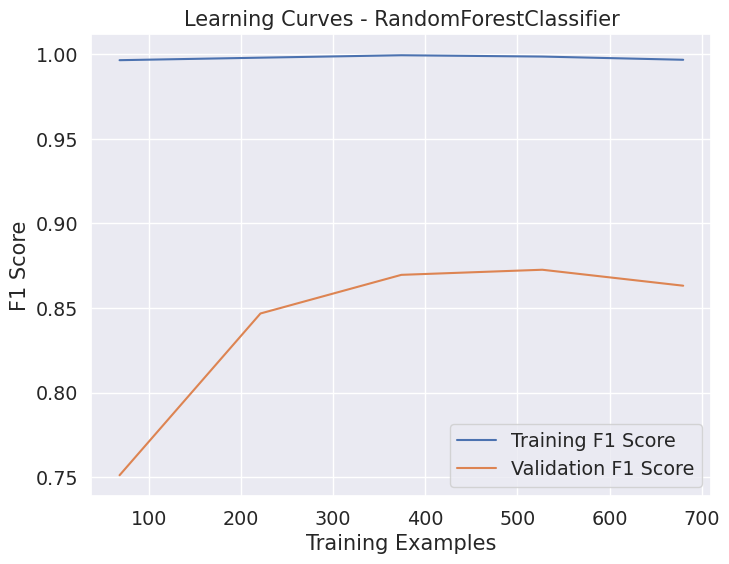

Going through each model defined in the dictionnary...:  40%|████      | 2/5 [00:56<01:37, 32.48s/it]

Fitting 10 folds for each of 24 candidates, totalling 240 fits


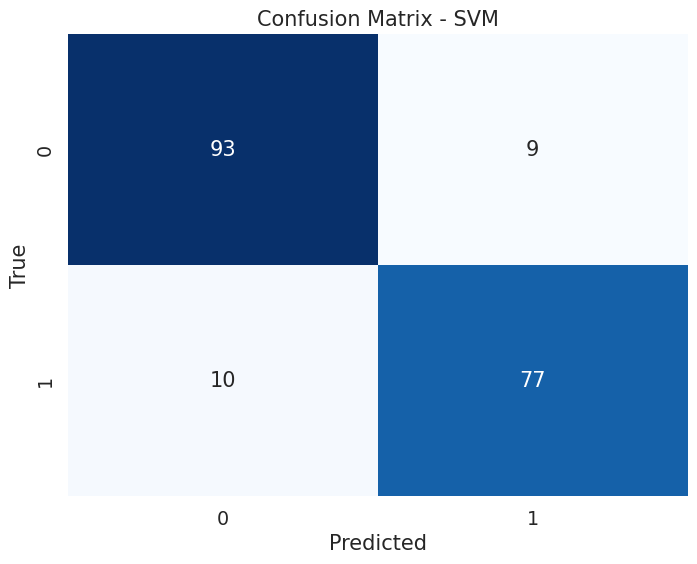

Model: SVM
Accuracy: 0.8994708994708994
Precision: 0.8953488372093024
Recall: 0.8850574712643678
ROC-AUC: 0.9522199684471491




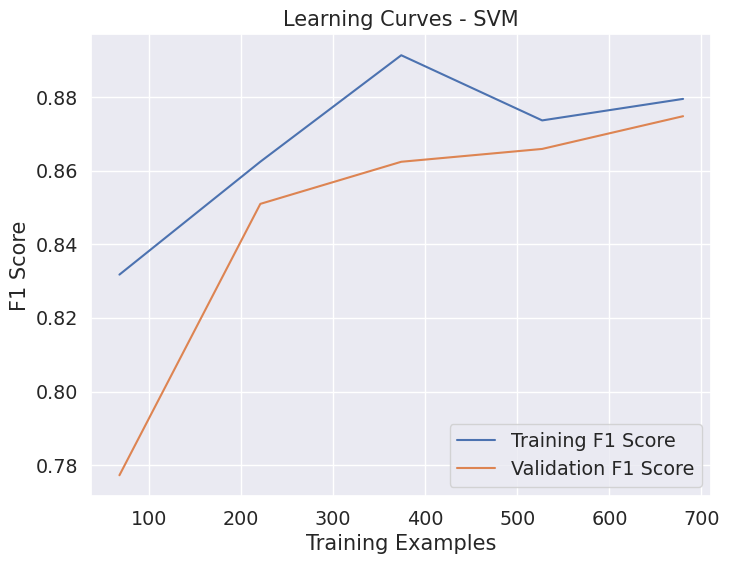

Going through each model defined in the dictionnary...:  60%|██████    | 3/5 [01:01<00:40, 20.00s/it]

Fitting 10 folds for each of 16 candidates, totalling 160 fits


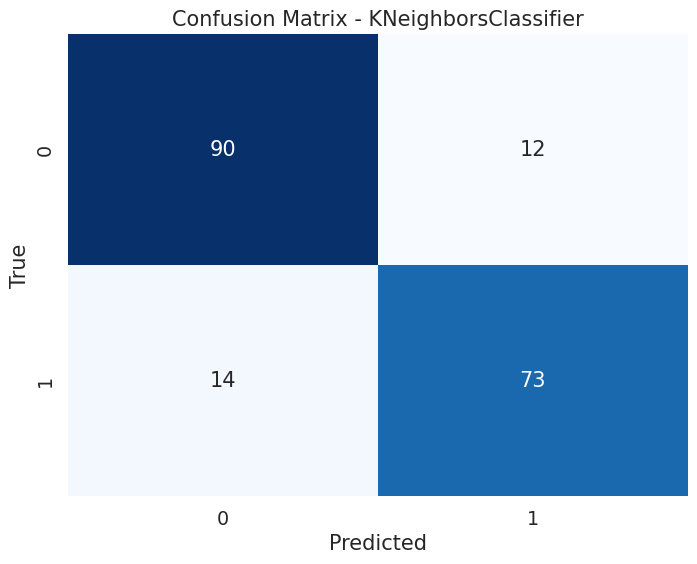

Model: KNeighborsClassifier
Accuracy: 0.8624338624338624
Precision: 0.8588235294117647
Recall: 0.8390804597701149
ROC-AUC: 0.9389226955149875




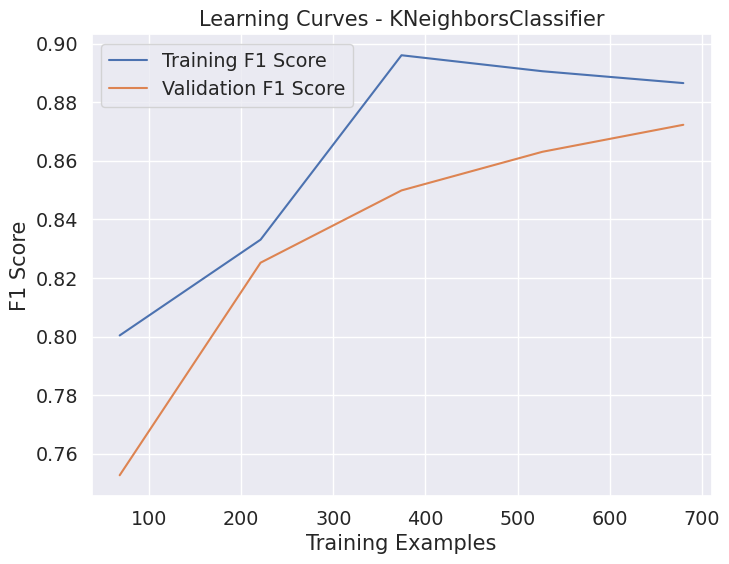

Going through each model defined in the dictionnary...:  80%|████████  | 4/5 [01:03<00:13, 13.07s/it]

Fitting 10 folds for each of 54 candidates, totalling 540 fits


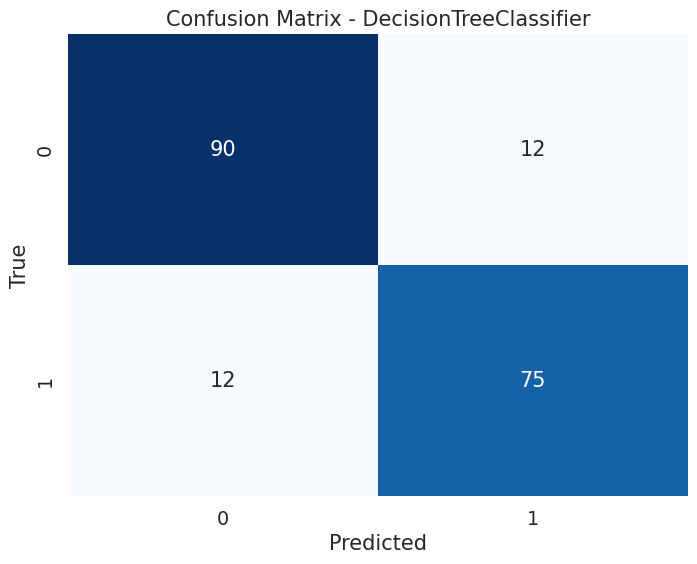

Model: DecisionTreeClassifier
Accuracy: 0.873015873015873
Precision: 0.8620689655172413
Recall: 0.8620689655172413
ROC-AUC: 0.9165539779130043




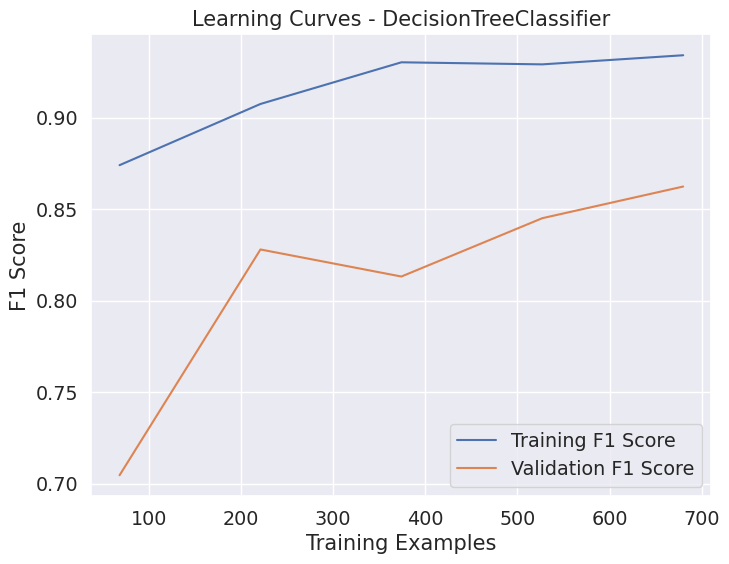

Going through each model defined in the dictionnary...: 100%|██████████| 5/5 [01:06<00:00, 13.33s/it]


,Model Name,f1 scoring on farm data(%)
0,Logistic Regression,88.370000
1,RandomForestClassifier,89.270000
2,SVM,89.020000
3,KNeighborsClassifier,84.880000
4,DecisionTreeClassifier,86.210000


In [40]:
from sklearn.model_selection import train_test_split
Xs_train,Xs_test,ys_train,ys_test = train_test_split(Xs,Ys,test_size=.20,random_state=203)
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
display_results(dict_models, Xs_train, ys_train, Xs_test, ys_test, cvs, 'f1 scoring on farm data(%)')

### After Min-Max scaling

In [36]:
Xm = minmax # 'R17','R32', R14, R2
Ym = farm['DIFF'] #Target


Going through each model defined in the dictionnary...:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/home/naim/Bureau/Binary-classification/classification_workflow.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)


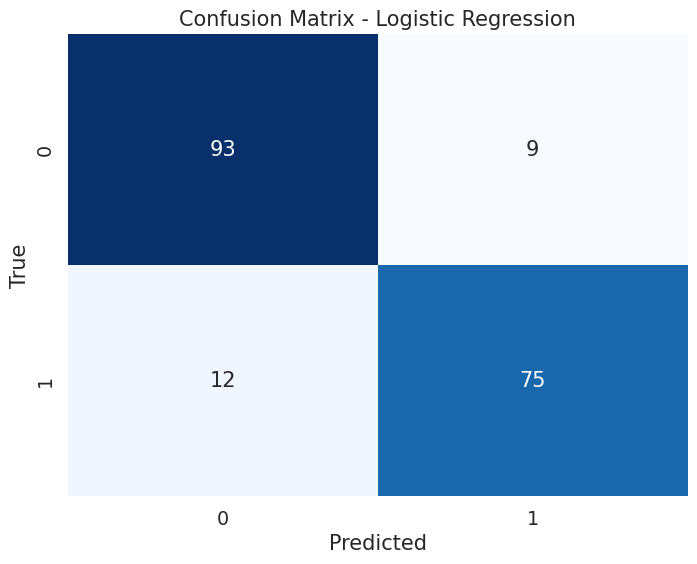

Model: Logistic Regression
Accuracy: 0.8888888888888888
Precision: 0.8928571428571429
Recall: 0.8620689655172413
ROC-AUC: 0.9523326572008114




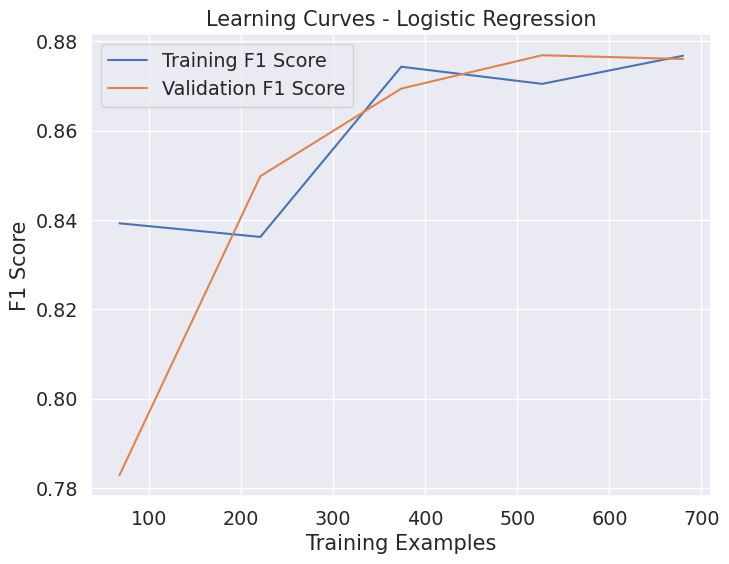

Going through each model defined in the dictionnary...:  20%|██        | 1/5 [00:03<00:12,  3.03s/it]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


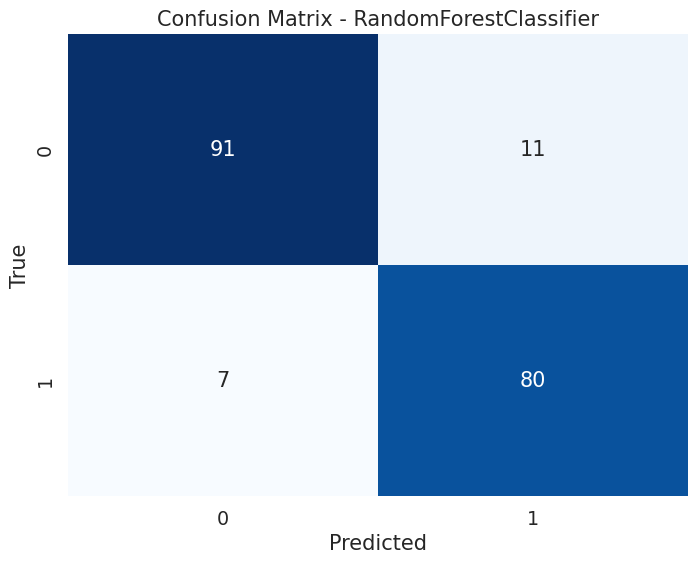

Model: RandomForestClassifier
Accuracy: 0.9047619047619048
Precision: 0.8791208791208791
Recall: 0.9195402298850575
ROC-AUC: 0.9593193599278793




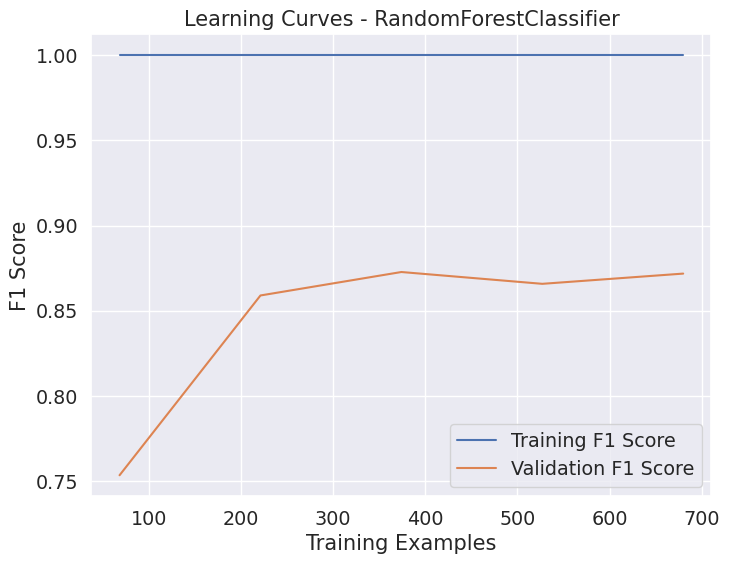

Going through each model defined in the dictionnary...:  40%|████      | 2/5 [01:01<01:46, 35.60s/it]

Fitting 10 folds for each of 24 candidates, totalling 240 fits


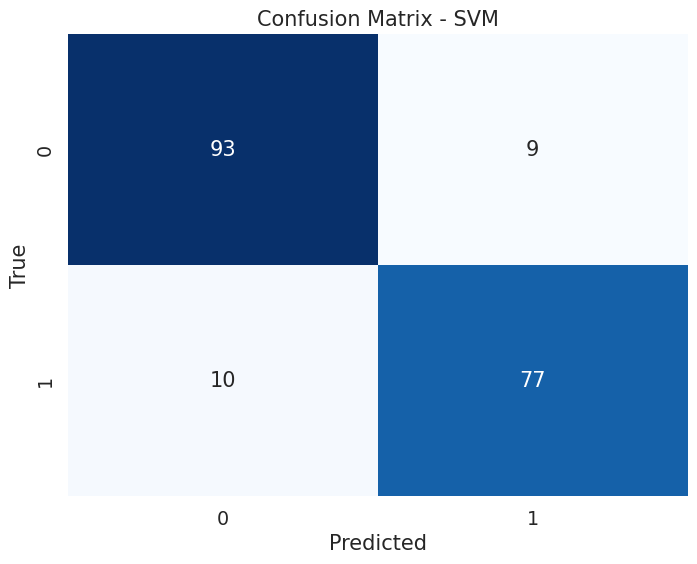

Model: SVM
Accuracy: 0.8994708994708994
Precision: 0.8953488372093024
Recall: 0.8850574712643678
ROC-AUC: 0.956614829839982




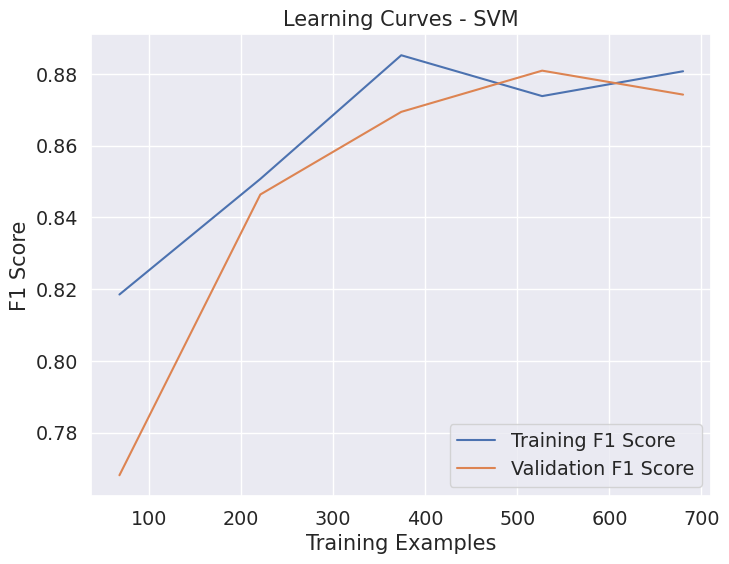

Going through each model defined in the dictionnary...:  60%|██████    | 3/5 [01:09<00:46, 23.05s/it]

Fitting 10 folds for each of 16 candidates, totalling 160 fits


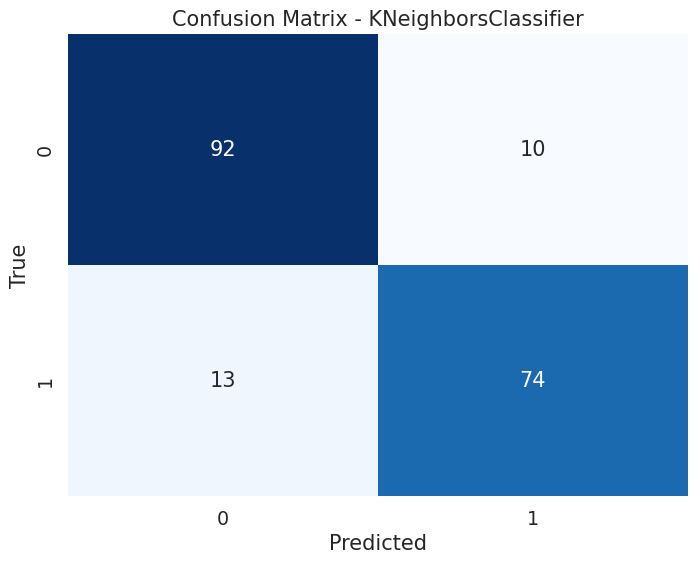

Model: KNeighborsClassifier
Accuracy: 0.8783068783068783
Precision: 0.8809523809523809
Recall: 0.8505747126436781
ROC-AUC: 0.9461911201262114




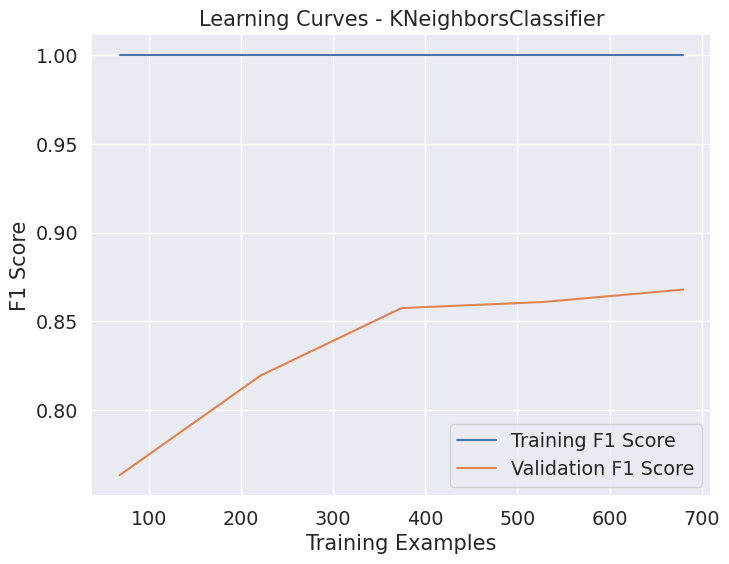

Going through each model defined in the dictionnary...:  80%|████████  | 4/5 [01:11<00:14, 14.67s/it]

Fitting 10 folds for each of 54 candidates, totalling 540 fits


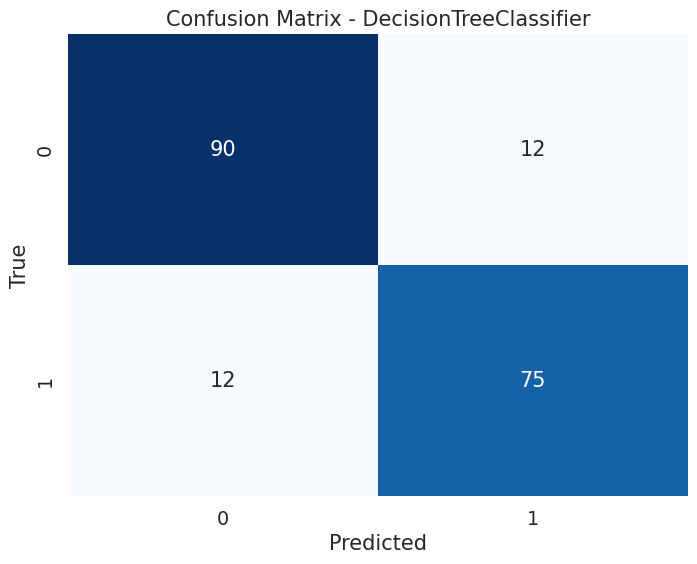

Model: DecisionTreeClassifier
Accuracy: 0.873015873015873
Precision: 0.8620689655172413
Recall: 0.8620689655172413
ROC-AUC: 0.9166666666666667




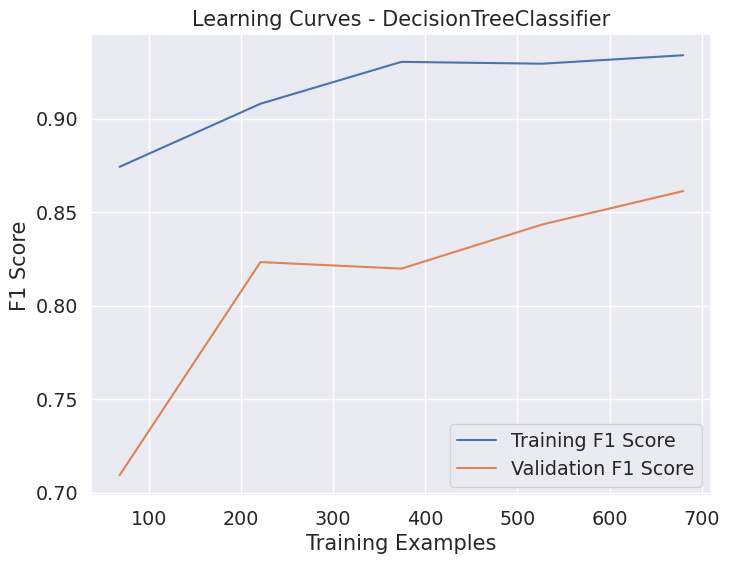

Going through each model defined in the dictionnary...: 100%|██████████| 5/5 [01:14<00:00, 14.88s/it]


,Model Name,f1 scoring on farm data(%)
0,Logistic Regression,87.720000
1,RandomForestClassifier,89.890000
2,SVM,89.020000
3,KNeighborsClassifier,86.550000
4,DecisionTreeClassifier,86.210000


In [41]:
from sklearn.model_selection import train_test_split
Xm_train,Xm_test,ym_train,ym_test = train_test_split(Xm,Ym,test_size=.20,random_state=203)
cvm = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
display_results(dict_models, Xm_train, ym_train, Xm_test, ym_test, cvm, 'f1 scoring on farm data(%)')

# Analyse disciminante linéaire



# Bayésien naïf 